In [7]:
# Test the central difference matrices
include("./src/finite_diff.jl")
using Printf
# pbc f(0,y) = f(x_max,y),f(x,0) = f(x,y_max)
# descritization: delta_x = x_max/nx, delta_y = y_max/ny
# descretised field f[1 2... nx, 1 2... ny] 
# pbc: f[0,...] = f[nx,...] and f[...,0]=f[...,ny]
# f[0,...] and f[... ,0] are not included in the lattice 

x_max = y_max = 2.0*pi
nx = 128
ny = 128
N = nx*ny
delta_x = x_max/nx
delta_y = y_max/ny

x = range(delta_x,2*pi,nx)
y = transpose(range(delta_y,2*pi,ny))
f = @. sin(x)*cos(2.0*y)

# 0th order derivative
exact_derivatives = Dict((0,0)=>f)
# first derivatives(exact)
exact_derivatives[(1,0)] = @. cos(x)*cos(2.0*y)      #df/dx
exact_derivatives[(0,1)] = @. -2.0*sin(x)*sin(2.0*y) # dy/dx
# second derivatives(exact)
exact_derivatives[(2,0)] = @. -sin(x)*cos(2.0*y)     #d2f/dx2
exact_derivatives[(0,2)] = @. -4.0*sin(x)*cos(2.0*y) #d2d/dy2
exact_derivatives[(1,1)] = @. -2.0*cos(x)*sin(2.0*y) #d2/dxdy
# third derivatives(exact)
exact_derivatives[(3,0)] = @. -cos(x)*cos(2.0*y)     #d3f/dx3
exact_derivatives[(2,1)] = @. 2.0*sin(x)*sin(2.0*y) #d/dy d2f/dx2 
exact_derivatives[(1,2)] = @. -4.0*cos(x)*cos(2.0*y) #d/dx d2f/dy2 
exact_derivatives[(0,3)] = @. 8.0*sin(x)*sin(2.0*y)  #d3f/dy3 
# fourth derivatives(exact)
exact_derivatives[(4,0)] = @. sin(x)*cos(2.0*y)       #d4f/dx4
exact_derivatives[(3,1)] = @. 2.0*cos(x)*sin(2.0*y)   #d/dy d3f/dx3 
exact_derivatives[(2,2)] = @. 4.0*sin(x)*cos(2.0*y)   #d^2/dx^2 d2f/dy2 
exact_derivatives[(1,3)] = @. 8.0*cos(x)*sin(2.0*y)  #d^4f/dy4
exact_derivatives[(0,4)] = @. 16.0*sin(x)*cos(2.0*y)  #d^4f/dy4
oacc = 2
@printf("Test central difference scheme order of accuary=%i \n",oacc)
for odx in 0:2
    for ody in 0:2
        if odx + ody <= 4 && odx + ody > 0
            if odx == 0
                Dx = 1.0
            else
                Dx = diff_mat2d(nx,ny,1,odx,"central",oacc)/(delta_x^odx)
            end
            if ody == 0
                Dy = 1.0
            else
                Dy = diff_mat2d(nx,ny,2,ody,"central",oacc)/(delta_y^ody)
            end
            cdiff = Dx*Dy*reshape(f,(N,1))
            cdiff = reshape(cdiff,(nx,ny))
            rmse = sqrt(1.0/N*sum((cdiff - exact_derivatives[(odx,ody)]).^2))
            @printf("RMSE for [d/dx]^%i [d/dy]^%i is %1.8f \n",odx,ody,rmse)
        end
    end
end

oacc = 4
@printf("Test foward difference scheme order of accuary=%i \n",oacc)
for odx in 0:2
    for ody in 0:2
        if odx + ody <= 4 && odx + ody > 0
            if odx == 0
                Dx = 1.0
            else
                Dx = diff_mat2d(nx,ny,1,odx,"forward",oacc)/(delta_x^odx)
            end
            if ody == 0
                Dy = 1.0
            else
                Dy = diff_mat2d(nx,ny,2,ody,"forward",oacc)/(delta_y^ody)
            end
            cdiff = Dx*Dy*reshape(f,(N,1))
            cdiff = reshape(cdiff,(nx,ny))
            rmse = sqrt(1.0/N*sum((cdiff - exact_derivatives[(odx,ody)]).^2))
            @printf("RMSE for [d/dx]^%i [d/dy]^%i is %1.8f \n",odx,ody,rmse)
        end
    end
end

# test the laplacian operators
ll = laplacian_square_stencil(nx,ny,"isotropic_std")
ll_diff = ll*reshape(f,(N,1))
ll_diff = reshape(ll_diff,(nx,ny))
exact_laplacian = exact_derivatives[(2,0)] +  exact_derivatives[(0,2)]
rmse = sqrt(1.0/N*sum((ll_diff - exact_laplacian).^2))
@printf("RMSE for the standard isotropic laplacian is %1.8f \n",rmse)

ll = laplacian_square_stencil(nx,ny,"isotropic_sto")/(delta_y^2)
ll_diff = ll*reshape(f,(N,1))
ll_diff = reshape(ll_diff,(nx,ny))
exact_laplacian = exact_derivatives[(2,0)] +  exact_derivatives[(0,2)]
rmse = sqrt(1.0/N*sum((ll_diff - exact_laplacian).^2))
@printf("RMSE for the stochastic isotropic laplacian is %1.8f \n",rmse)


Test central difference scheme order of accuary=2 
RMSE for [d/dx]^0 [d/dy]^1 is 0.00160561 
RMSE for [d/dx]^0 [d/dy]^2 is 0.00160586 
RMSE for [d/dx]^1 [d/dy]^0 is 0.00020077 
RMSE for [d/dx]^1 [d/dy]^1 is 0.00200651 
RMSE for [d/dx]^1 [d/dy]^2 is 0.00240831 
RMSE for [d/dx]^2 [d/dy]^0 is 0.00010039 
RMSE for [d/dx]^2 [d/dy]^1 is 0.00180607 
RMSE for [d/dx]^2 [d/dy]^2 is 0.00200711 
Test foward difference scheme order of accuary=4 
RMSE for [d/dx]^0 [d/dy]^1 is 0.00001855 
RMSE for [d/dx]^0 [d/dy]^2 is 0.00014111 
RMSE for [d/dx]^1 [d/dy]^0 is 0.00000058 
RMSE for [d/dx]^1 [d/dy]^1 is 0.00001969 
RMSE for [d/dx]^1 [d/dy]^2 is 0.00014338 
RMSE for [d/dx]^2 [d/dy]^0 is 0.00000221 
RMSE for [d/dx]^2 [d/dy]^1 is 0.00002290 
RMSE for [d/dx]^2 [d/dy]^2 is 0.00014973 
RMSE for the standard isotropic laplacian is 0.00290983 
RMSE for the stochastic isotropic laplacian is 0.01002184 


In [30]:
# Test the numerical integration using Simpson's rule
include("./src/finite_diff.jl")
using Printf
x = collect(range(0.0,1.0;length=20))
y = 4.0*x.^3
s = simpson_int1d(y,(0.0,1.0))
@printf("int 4x^3 from 0 to 1 is %1.8f, error is %1.8f\n",s,abs(1.0-s))

x  = collect(range(0.0,1.0*pi;length=20))
y = sin.(x)
s = simpson_int1d(y,(0.0,1.0*pi))
@printf("int sin(x) from 0 to pi is %1.8f, error is %1.8f\n",s,abs(2.0-s))

N = 100
x = collect(range(-4.0,4.0;length=N))
y = collect(range(-4.0,4.0;length=N))
z = exp.(-x.*x .- y'.*y').*(x.^2 .+ y.^2')'.*(x.^2 .+ y.^2')
@printf(" %1.8f\n",sum(z)*64/(N*N))

s = simpson_int2d(z,(-4.0,4.0),(-4.0,4.0))
@printf("int exp(-(x^2+y^2))*(x^2+y^2) in [-4,4]*[-6,6] %1.8f, error is %1.8f\n",s,abs(pi-s))




int 4x^3 from 0 to 1 is 0.93536217, error is 0.06463783
int sin(x) from 0 to pi is 1.99544132, error is 0.00455868
 3.07907265
int exp(-(x^2+y^2))*(x^2+y^2) in [-4,4]*[-6,6] 3.14158892, error is 0.00000374


In [21]:
# test the convolusion integral
# calculate the convolusion between exp(-(x-10)^2)exp(-(y-10)^2) and (x+y) at point(u,v) = (10,10)
#  = ∫∫dxdy exp(-x^2)exp(-y^2)[(u-x)+(v-y)] = (u+v)*pi
using Printf
include("./src/finite_diff.jl")
Nw = 128
rx = collect(range(-5.0,5.0;length=2*Nw+1))
ry = collect(range(-5.0,5.0;length=2*Nw+1))
k = exp.(-rx.^2 .- (ry.^2)')

dx = 10.0/(2*Nw)
dy = 10.0/(2*Nw)

xx = collect(dx:dx:20.0)
yy = collect(dy:dy:20.0)
g = xx .+ yy'

# the index of point (10,10)
cx,cy = trunc(Int,10.0/dx),trunc(Int,10.0/dy)

s = convol2d(g,k,(cx,cy),dx,dy)

#@printf("%1.8f\n",sum(i)*dx*dy)

# convolusion is
# 
# the correlation integral is int dxdy exp((10-x)^2+(10-y)^2))*((10-x)^2+(10-y)^2)
@printf(" ∫∫dxdy exp(-x^2)exp(-y^2)[(u-x)+(v-y)] ≈ %1.8f, error is %1.8f\n",s,abs(20*pi-s))



 ∫∫dxdy exp(-x^2)exp(-y^2)[(u-x)+(v-y)] ≈ 62.58641615, error is 0.24543693


In [32]:
# test the mean field model
include("./src/mean_field_model_gradient.jl")
using Printf
x_max = y_max = 2.0*pi
nx = ny = 256
N = nx*ny
T = 0.1
A = 0.1
B = 0.01
C = 0.01
K = 0.01
Gamma = 1.0
dt = 0.01

model = NumericalMeanField2D(x_max, y_max, nx, ny, dt)


set_model_params(model, T, A, B, C, K)
x = model.x
y = model.y'
rho = @. sin(x) * cos(2.0 * y)
rho_dx = @. cos(x) * cos(2.0 * y)
rho_dy = @. -2.0 * sin(x) * sin(2.0 * y)

rho_dxy = @. -2.0 * cos(x) * sin(2.0 * y)
rho_dxx = @. -sin(x) * cos(2.0 * y)
rho_dyy = @. -4.0 * sin(x) * cos(2.0 * y)
mu = @. 2.0*A * rho + 3.0*B * rho^ 2 - 2.0*K * (-5.0 * sin(x) * cos(2.0 * y))

j = zeros(Float64, 2, nx, ny)
j[1, :, :] = @. rho * (2.0*A * rho_dx + 6.0 * B * rho * rho_dx - 2.0*K * (-5.0 * cos(x) * cos(2.0 * y))) + T*rho_dx
j[2, :, :] = @. rho * (2.0*A * rho_dy + 6.0 * B * rho * rho_dy - 2.0*K * (10.0 * sin(x) * sin(2.0 * y))) + T*rho_dy
f = zeros(Float64, 2, nx, ny)

#sigma_xx = @. -C*(sin(x) * cos(2.0 * y))^2
#sigma_xy = @. -C*0.5 * sin(2.0 * x) * sin(4.0 * yprintln(rho))
#sigma_yy = @. -C*4.0 * (sin(x) * cos(2.0 * y))^2

f = zeros(Float64, 2, nx, ny)
f[1, :, :] = @. 2.0*C*(-sin(2.0 * x) * (cos(2.0 * y)^2) - 2.0 * sin(2.0 * x) * cos(4.0 * y))
f[2, :, :] = @. 2.0*C*(-cos(2.0 * x)* sin(4.0 * y) + 8.0 * sin(x)^2 * sin(4.0 * y))

set_initial_condition(model,rho)
update_parallel!(model)
rho_fd = reshape(model.rho,nx,ny)
rmse = sqrt(1.0/N*sum((rho_fd - rho).^2))
@printf("RMSE for rho is %1.8f \n",rmse)

# rmse of mu
mu_fd = reshape(model.mu,nx,ny)
rmse_mu = sum(abs.(mu_fd - mu))/sum(abs.(mu))
@printf("RMSE for mu is %1.8f \n",rmse_mu)
println(mu_fd[10,10])
println(mu[10,10])

# rmse of j
for alpha in 1:2
    j_fd = reshape(model.j[alpha, :, :],(nx,ny))
    rmse_j = sum(abs.(j_fd - j[alpha, :, :]))/sum(abs.(j[alpha, :, :]))
    @printf("RMSE for the %i th component of flux, j, is %1.8f \n",alpha,rmse_j)
end

# rmse of f
for alpha in 1:2
    f_fd = reshape(model.f[alpha, :, :],(nx,ny))
    rmse_f = sum(abs.(f_fd - f[alpha, :, :]))/sum(abs.(f[alpha, :, :]))
    @printf("RMSE for the %i th component of force density, f, is %1.8f \n",alpha,rmse_f)
end


LoadError: LoadError: invalid redefinition of constant NumericalMeanField2D
in expression starting at /home/richard/Documents/code/Bromf/src/mean_field_model_gradient.jl:12

In [46]:
include("./src/mean_field_model_integral.jl")
using Printf
x_max = y_max = 60.0
nx = ny = 64
N = nx*ny
T = 10.0
R = 1.0
D = 0.0
Gamma = 1.0
dt = 0.002
# the analtical solution for 2d difustion euqation with Gaussian initial condition
# dt u = T*(dxx u + dyy u)
# rho(x,y) = 1/t*exp(-(x-x0)^2-(y-y0)^2/(4T*t))
model = NumericalMeanField2D(x_max, y_max, nx, ny, dt, "julia-Tsit5")
x = model.x 
y = model.y'
t0 = 1.0
rho_0 =  @. 1.0/t0*exp((-(x - 0.5*x_max)^2 - (y -0.5*y_max)^2)/(4*T*t0))
set_model_params(model,T,D,R,Gamma)
set_initial_condition(model,rho_0)
nsteps = [1,10,100,200,500,1000]
for nstep in nsteps
    t = dt*nstep
    rho_t = @. 1.0/(t+t0)*exp((-(x - 0.5*x_max)^2 - (y -0.5*y_max)^2)/(4*T*(t+t0)))
    set_initial_condition(model,rho_0)
    #for i in 1:nstep
    #    one_step(model)
    #end
    n_steps(model,nstep)
    rho_fd = reshape(model.rho,nx,ny)
    rmse = sum(abs.(rho_fd-rho_t))/sum(abs.(rho_t))
    @printf("RMSE for the t=%1.6f of density, rho, is %1.8f \n",t,rmse)
end



RMSE for the t=0.002000 of density, rho, is 0.00022891 
RMSE for the t=0.020000 of density, rho, is 0.00214894 
RMSE for the t=0.200000 of density, rho, is 0.01308545 
RMSE for the t=0.400000 of density, rho, is 0.01690805 
RMSE for the t=1.000000 of density, rho, is 0.01686521 
RMSE for the t=2.000000 of density, rho, is 0.01297478 


In [47]:
# test the conservation of density field
include("./src/mean_field_model_integral.jl")
using Printf
using Random, Distributions
using Plots
x_max = y_max = 60.0
nx = ny = 32
N = nx*ny
T = 0.0
R = 0.5
D = 0.00
Gamma = 1.0
dt = 0.001
# the analtical solution for 2d difustion euqation with Gaussian initial condition
# dt u = D*(dxx u + dyy u)
# rho(x,y) = 1/t*exp(-(x-x0)^2-(y-y0)^2/(4D*t))
model = NumericalMeanField2D(x_max, y_max, nx, ny, dt, "julia-Tsit5")
x = model.x 
y = model.y'
#rho_0 =  @. 1.0/t0*exp((-(x - 0.5*x_max)^2 - (y -0.5*y_max)^2)/(4*T*t0))
rho_0 = rand(Normal(0.01, 0.001), nx,ny)
set_model_params(model,T,D,R,Gamma)
set_initial_condition(model,rho_0)
for nstep in 1:10
    #for i in 1:nstep
    #    one_step(model)
    #end
    n_steps(model,4000000)
    rho_fd = reshape(model.rho,nx,ny)
    @printf("mean of rho is %1.8f \n",mean(rho_fd))
    @printf("vairance of rho is %1.8f \n",var(rho_fd))
    #heatmap(rho_fd)
end
heatmap(reshape(model.rho,nx,ny))



mean of rho is 0.00996870 
vairance of rho is 0.00000100 
mean of rho is 0.00996870 
vairance of rho is 0.00000100 
mean of rho is 0.00996870 
vairance of rho is 0.00000100 
mean of rho is 0.00996870 
vairance of rho is 0.00000100 
mean of rho is 0.00996870 
vairance of rho is 0.00000100 
mean of rho is 0.00996870 
vairance of rho is 0.00000100 
mean of rho is 0.00996870 
vairance of rho is 0.00000100 
mean of rho is 0.00996870 
vairance of rho is 0.00000100 
mean of rho is 0.00996870 
vairance of rho is 0.00000100 


: 

: 

sum of rho is 10.34869339 
vairance of rho is 0.00000029 
sum of rho is 10.37357278 
vairance of rho is 0.00000014 
sum of rho is 10.37850399 
vairance of rho is 0.00000009 
sum of rho is 10.37984012 
vairance of rho is 0.00000007 
sum of rho is 10.38032208 
vairance of rho is 0.00000005 
sum of rho is 10.38053839 
vairance of rho is 0.00000004 
sum of rho is 10.38065088 
vairance of rho is 0.00000004 
sum of rho is 10.38071541 
vairance of rho is 0.00000003 
sum of rho is 10.38075510 
vairance of rho is 0.00000003 
sum of rho is 10.38078084 
vairance of rho is 0.00000003 


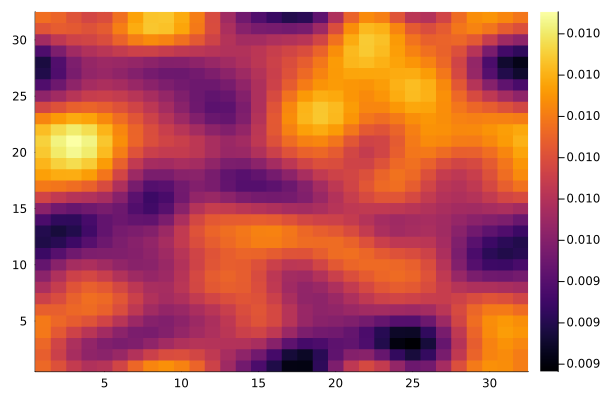

In [18]:
# test the conservation of density field
include("./src/mean_field_model_integral.jl")
using Printf
using Random, Distributions
using Plots
x_max = y_max = 60.0
nx = ny = 32
N = nx*ny
T = 0.0
R = 0.5
D = 0.00
Gamma = 1.0
dt = 0.001
# the analtical solution for 2d difustion euqation with Gaussian initial condition
# dt u = D*(dxx u + dyy u)
# rho(x,y) = 1/t*exp(-(x-x0)^2-(y-y0)^2/(4D*t))
model = NumericalMeanField2D(x_max, y_max, nx, ny, dt, "julia-Tsit5")
x = model.x 
y = model.y'
#rho_0 =  @. 1.0/t0*exp((-(x - 0.5*x_max)^2 - (y -0.5*y_max)^2)/(4*T*t0))
rho_0 = rand(Normal(0.01, 0.001), nx,ny)
set_model_params(model,T,D,R,Gamma)
set_initial_condition(model,rho_0)
for nstep in 1:10
    #for i in 1:nstep
    #    one_step(model)
    #end
    n_steps(model,4000000)
    rho_fd = reshape(model.rho,nx,ny)
    @printf("sum of rho is %1.8f \n",sum(rho_fd))
    @printf("vairance of rho is %1.8f \n",var(rho_fd))
    #heatmap(rho_fd)
end
heatmap(reshape(model.rho,nx,ny))

123456789101112131415161718192021222324252627282930

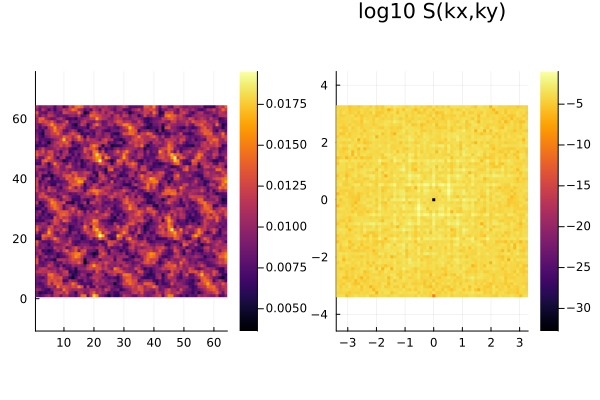

In [10]:
# test the implementation of nosie
include("./src/mean_field_model_integral.jl")
include("./src/utils.jl")
using Printf
using Random, Distributions
using Plots

x_max = y_max = 60.0
nx = ny = 64
N = nx*ny
T = 0.0
R = 4.0
D = 0.05
Gamma = 1.0
dt = 0.001
# the analtical solution for 2d difustion euqation with Gaussian initial condition
# dt u = D*(dxx u + dyy u)
# rho(x,y) = 1/t*exp(-(x-x0)^2-(y-y0)^2/(4D*t))
model = NumericalMeanField2D(x_max, y_max, nx, ny, dt, "forward-Euler")
x = model.x 
y = model.y'
#rho_0 =  @. 1.0/t0*exp((-(x - 0.5*x_max)^2 - (y -0.5*y_max)^2)/(4*T*t0))
rho_0 = rand(Normal(0.01, 0.001), nx,ny)
set_model_params(model,T,D,R,Gamma)
set_initial_condition(model,rho_0)
for nstep in 1:30
    one_step(model)
    rho = reshape(model.rho,nx,ny)
    print(nstep)
    #heatmap(rho_fd)
end
p1 = heatmap(reshape(model.rho,nx,ny),aspect_ratio=:equal,tellheight=true,interpolate=true,)
kx,ky,s_2d = get_structure_factor(model.rho,nx,ny,x_max,y_max)
# plot the struture factor
p2 = heatmap(kx,ky,log10.(s_2d)',aspect_ratio=:equal,tellheight=true,interpolate=true,title="log10 S(kx,ky)")
p = plot(p1,p2,layout=(1,2))